In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('../input/course-study/appendix.csv')
data

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
0,MITx,6.002x,09/05/2012,Circuits and Electronics,Khurram Afridi,"Science, Technology, Engineering, and Mathematics",1,1,36105,5431,3003,15.04,8.32,54.98,83.2,8.17,28.97,418.94,64.45,26.0,88.28,11.72,60.68
1,MITx,6.00x,09/26/2012,Introduction to Computer Science and Programming,"Eric Grimson, John Guttag, Chris Terman",Computer Science,1,1,62709,8949,5783,14.27,9.22,64.05,89.14,14.38,39.50,884.04,78.53,28.0,83.50,16.50,63.04
2,MITx,3.091x,10/09/2012,Introduction to Solid State Chemistry,Michael Cima,"Science, Technology, Engineering, and Mathematics",1,1,16663,2855,2082,17.13,12.49,72.85,87.49,14.42,34.89,227.55,61.28,27.0,70.32,29.68,58.76
3,HarvardX,CS50x,10/15/2012,Introduction to Computer Science,"David Malan, Nate Hardison, Rob Bowden, Tommy ...",Computer Science,1,1,129400,12888,1439,9.96,1.11,11.11,0,0.00,1.11,220.90,0.00,28.0,80.02,19.98,58.78
4,HarvardX,PH207x,10/15/2012,Health in Numbers: Quantitative Methods in Cli...,"Earl Francis Cook, Marcello Pagano","Government, Health, and Social Science",1,1,52521,10729,5058,20.44,9.64,47.12,77.45,15.98,32.52,804.41,76.10,32.0,56.78,43.22,88.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,HarvardX,MUS24.4x,07/21/2016,First Nights: Symphonie Fantastique,Tom Kelly,"Humanities, History, Design, Religion, and Edu...",4,0,615,305,20,49.59,3.25,6.56,80.81,8.78,3.25,1.71,5.93,38.0,56.82,43.18,74.66
286,HarvardX,GSE4x,07/25/2016,Introduction to Family Engagement in Education,Karen Mapp,"Humanities, History, Design, Religion, and Edu...",4,0,2871,267,20,9.30,0.70,7.49,70.11,0.00,0.70,4.26,11.33,34.0,25.24,74.76,82.31
287,MITx,6.302.0x,08/01/2016,Introduction to Control System Design,"Jacob White, Joe Steinmeyer","Science, Technology, Engineering, and Mathematics",4,0,3937,974,49,24.74,1.24,5.03,12.27,4.72,8.23,15.62,58.50,24.0,91.17,8.83,61.32
288,MITx,6.302.1x,08/01/2016,Introduction to State Space Control,"Jacob White, Joe Steinmeyer","Science, Technology, Engineering, and Mathematics",4,0,1431,208,8,14.54,0.56,3.85,0,3.84,5.73,3.22,62.38,25.0,93.44,6.56,72.31


In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop unused columns
    df = df.drop(['Course Number', 'Course Title', 'Instructors'], axis=1)
    
    # Fill missing values
    df['% Played Video'] = df['% Played Video'].replace('---', np.NaN).astype(float)
    df['% Played Video'] = df['% Played Video'].fillna(df['% Played Video'].mean())
    
    # Extract date features
    df['Launch Date'] = pd.to_datetime(df['Launch Date'])
    df['Launch Year'] = df['Launch Date'].apply(lambda x: x.year)
    df['Launch Month'] = df['Launch Date'].apply(lambda x: x.month)
    df['Launch Day'] = df['Launch Date'].apply(lambda x: x.day)
    df = df.drop('Launch Date', axis=1)
    
    # Split df into X and y
    y = df['Honor Code Certificates']
    X = df.drop('Honor Code Certificates', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)


In [7]:
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='if_binary'))
])

preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, ['Institution', 'Course Subject'])
], remainder='passthrough')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=1,
        class_weight={
            0: 1.0,
            1: 1.0
        }
    ))
])

In [8]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['Institution',
                                                   'Course Subject'])])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1.0, 1: 1.0},
                                        random_state=1))])

Accuracy: 95.40%


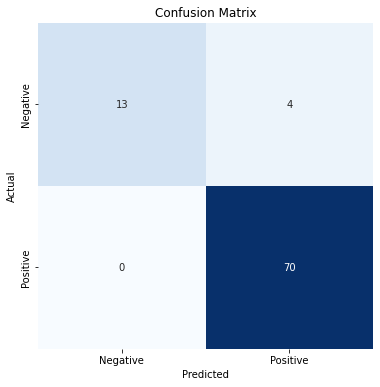

Classification Report:
---------------------
               precision    recall  f1-score   support

    Negative       1.00      0.76      0.87        17
    Positive       0.95      1.00      0.97        70

    accuracy                           0.95        87
   macro avg       0.97      0.88      0.92        87
weighted avg       0.96      0.95      0.95        87



In [9]:
y_pred = model.predict(X_test)

acc = model.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["Negative", "Positive"])

print("Accuracy: {:.2f}%".format(acc * 100))

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n---------------------\n", clr)